
# 1. Setup & Data Generation
First, we define a ground truth parametric curve and corrupt it with Gaussian noise to simulate sensor jitter.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from scipy.spatial.distance import directed_hausdorff
import time

In [2]:
def plot_strokes(strokes, labels, title="Stroke Comparison",
                 formats=None, alpha=None, figsize=(18, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    if formats is None:
        formats = ['-' for _ in strokes]

    if alpha is None:
        alpha = [0.8 for _ in strokes]

    for s, l, fmt, a in zip(strokes, labels, formats, alpha):
        ax.plot(s[:, 0], s[:, 1], fmt, label=l, alpha=a)
        ax.scatter(s[:, 0], s[:, 1], alpha=0.5)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_aspect(1)

    plt.show()


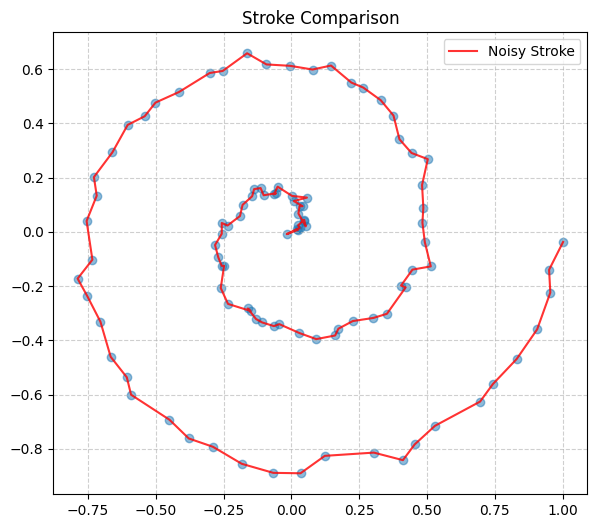

In [7]:
# Generate Synthetic Data
def generate_stroke(type='sine', n_points=100, noise_std=0.02):
    t = np.linspace(0,1, n_points)
    if type == 'sine':
        x = t
        y = np.sin(2 * np.pi * t)
    elif type == 'spiral':
        x = t * np.cos(4 * np.pi * t)
        y = t * np.sin(4 * np.pi * t)

    elif type == 'circle':
        t = np.linspace(0, 1, n_points, endpoint=False)
        theta = 2 * np.pi * t
        x = np.cos(theta)
        y = np.sin(theta)

    clean = np.column_stack((x, y))
    noise = np.random.normal(0, noise_std, clean.shape)
    return clean, clean + noise

ground_truth, noisy_stroke = generate_stroke('spiral')

plot_strokes(
    [noisy_stroke],
    ["Noisy Stroke"],
    formats=['r-', 'b-'],
    alpha=[0.8, 0.3]
)


# 2. Baseline Comparisons
We compare the Discrete Laplacian (Variational) method against standard signal processing filters.

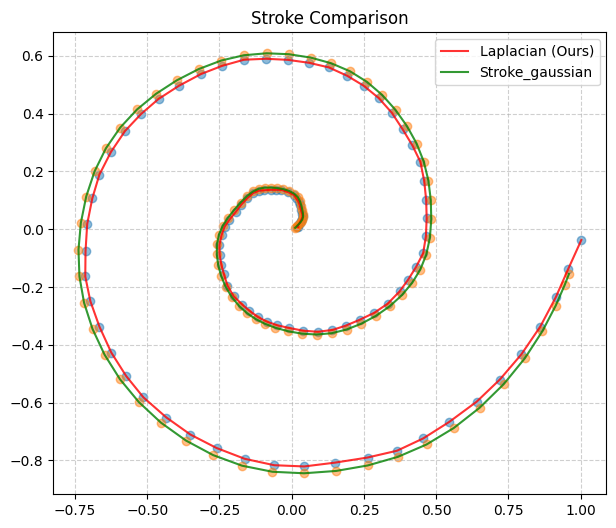

In [8]:
def laplacian_smooth(P_raw,lmbda=3, lr=0.05, iterations=100):
    Q = P_raw.copy()
    for _ in range(iterations):
        # Fidelity Gradient: (Q - P_raw)
        grad_fidelity = (Q - P_raw)

        # Laplacian (Curvature) Force: f_{i+1} - 2f_i + f_{i-1}
        lap = np.zeros_like(Q)
        lap[1:-1] = Q[2:] - 2*Q[1:-1] + Q[:-2]

        # Gradient Descent Step: Minimize J(Q)
        Q += lr * (-grad_fidelity + lmbda * lap)
    return Q


# stroke_laplace = laplacian_smooth(noisy_stroke, lmbda=4, iterations=250)

# Apply Baselines
stroke_gaussian = gaussian_filter1d(noisy_stroke, sigma=2, axis=0)

# stroke_savgol = savgol_filter(noisy_stroke, window_length=11, polyorder=3, axis=0)
stroke_laplace = laplacian_smooth(noisy_stroke, lmbda=4, iterations=250)
plot_strokes([stroke_laplace, stroke_gaussian], ["Laplacian (Ours)", "Stroke_gaussian"], formats=['r-', 'g-'])

# level_2_laplace = laplacian_smooth(stroke_laplace, lmbda=3, iterations=150)


# plot_strokes([noisy_stroke,stroke_laplace, level_2_laplace],
#              ["Noisy", "Laplacian(1)" , "Laplacian(2)"],
#              formats=['ro', 'g-', 'b-'])


## 6. Cubic Spline Fitting of Stroke Data
To fit a smooth curve to a 2D stroke, we use a **parametric spline** representation rather than a function of the form `y(x)`.  
This is necessary because strokes may loop, self-intersect, or move backward in `x`.

The stroke is modeled as a single curve:
$\mathbf{p}(u) = (x(u), y(u)), \quad u \in [0, 1]$

Internally, the spline consists of **two synchronized 1D splines**:
- one for the x-coordinate `x(u)`
- one for the y-coordinate `y(u)`

Both share the same parameter `u`, knots, and smoothing term, and together define a single 2D curve.

Finally, we use the optimized points as **knots for a Cubic Spline**, which ensures $(C^2)$ continuity across the entire stroke.

The smoothing parameter `s` controls the trade-off between fidelity and smoothness:
- `s = 0` gives exact interpolation
- larger `s` produces stronger denoising

This representation enables stable computation of derivatives such as velocity and curvature, and supports resampling by arc length.

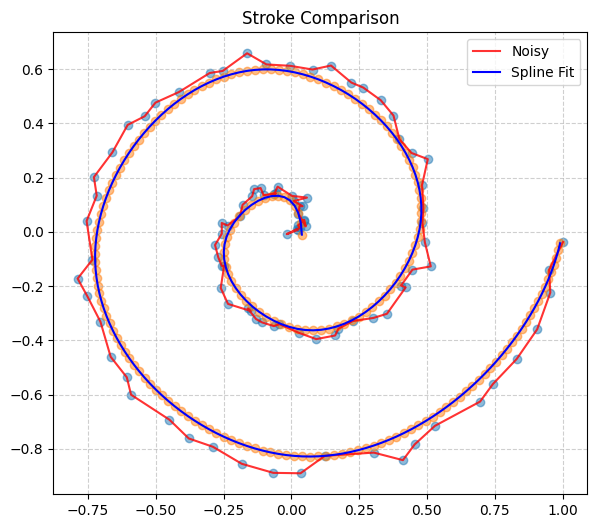

In [9]:
from scipy.interpolate import splprep, splev

def fit_spline(points, smoothing=0.001, n_samples=200):
    """
    points: (N, 2) array
    smoothing: larger = smoother
    n_samples: number of points on fitted spline
    """
    x, y = points[:, 0], points[:, 1]

    # Parametric spline
    tck, u = splprep([x, y], s=smoothing)

    # Sample spline
    u_new = np.linspace(0, 1, n_samples)
    x_s, y_s = splev(u_new, tck)

    return np.column_stack([x_s, y_s])

stroke_spline = fit_spline(stroke_laplace, smoothing=0.01)

plot_strokes(
    [noisy_stroke, stroke_spline],
    ["Noisy", "Spline Fit"],
    formats=['r-', 'b-'],
    alpha=[0.8, 1.0, 0.8]
)

In [12]:
def plot_c1_c2(points_dict):
    """
    Plots C1 (first derivative) and C2 (second derivative) of multiple sets of points
    directly from finite differences, without fitting a spline.

    points_dict: dict of {label: points_array (N,2)}
    """
    fig, axes = plt.subplots(3,1, figsize=(10,12), sharex=False)

    for label, points in points_dict.items():
        x, y = points[:,0], points[:,1]

        # First derivative (finite difference)
        dx = np.gradient(x)
        dy = np.gradient(y)

        # Second derivative (finite difference of first derivative)
        ddx = np.gradient(dx)
        ddy = np.gradient(dy)

        # Positions
        axes[0].plot(x, y, '-', label=label)
        axes[0].set_aspect(1)
        # axes[0].scatter(x, y, alpha=0.3)

        # First derivative (C1)
        axes[1].plot(dx, '-', label=f'{label} dx')
        axes[1].plot(dy, '--', label=f'{label} dy')

        # Second derivative (C2)
        axes[2].plot(ddx, '-', label=f'{label} d²x')
        axes[2].plot(ddy, '--', label=f'{label} d²y')

    # Formatting
    axes[0].set_title("Stroke Positions")
    axes[1].set_title("First Derivative (C1 continuity) - Finite Differences")
    axes[2].set_title("Second Derivative (C2 continuity) - Finite Differences")
    axes[2].set_xlabel("Point Index")

    for ax in axes:
        ax.grid(True)
        ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()


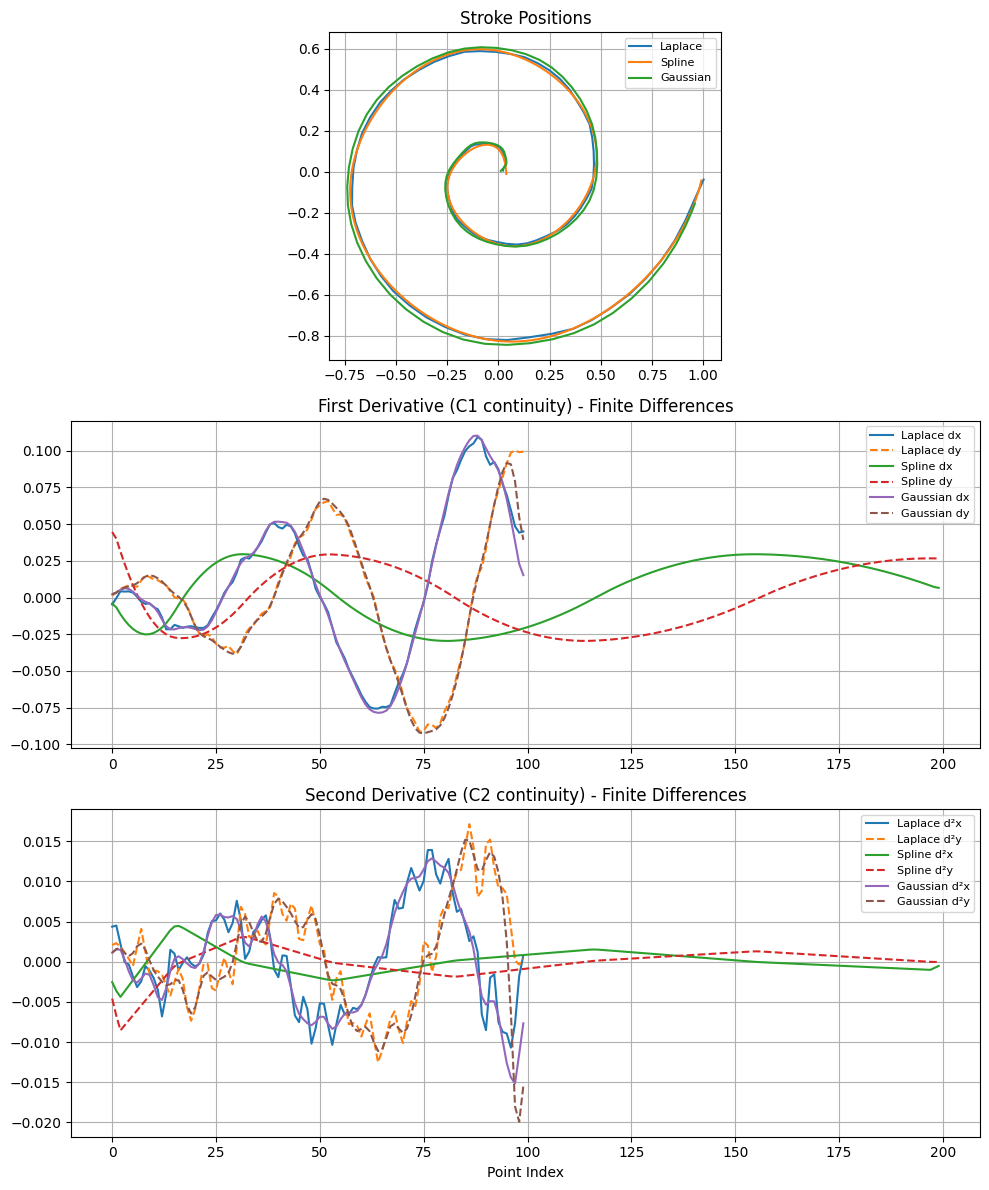

In [13]:
points_dict = {
    # "Rough": noisy_stroke,
    # "Original": ground_truth,
    "Laplace": stroke_laplace,
    "Spline": stroke_spline,
    "Gaussian": stroke_gaussian,
}

plot_c1_c2(points_dict)

Cubic spline smoothing is especially useful for natural phenomena because it ensures continuous position, velocity, and acceleration (C2 continuity).
This leads to smooth, physically plausible trajectories and shapes, unlike Gaussian smoothing which can still exhibit sharp changes in acceleration.
Additional advantages include easy derivative computations, compact curve representation, and controlled smoothness.